# Compare Multiclass Landsat 8 TIR Model Performance on Two PNG Workflows

* Original chip generation creates GeoTIFFs, then uses rasterio to normalize and create PNGs of type uint16 for use in deep learning
* New workflow uses RasterFrames for normalization, and rasterio to create PNGs.

Trained the same multi-class models on two sets of PNGS. Checking to see that they produce similar results.

**Results:** It does appear as if 8-bit PNG model suffers a bit in accuracy and recall.

## Install Fastai version 1.0.61

In [1]:
!pip install fastai==1.0.61

## Import libraries

In [2]:
import os
import boto3
from earthai.ml import *
import statistics

from fastai import *
from fastai.vision import *

## Download final models and .tar file from S3 bucket and extract contents

These tar files contains normalized PNGs for cement, steel, and landcover, divided into train and validate sets.

* Original model using rasterio for noramlization and PNG generation is denoted by `1`
* Refactored model using RasterFrames for normalization and rasterio for PNG generation is denoted by `2`

In [9]:
DATA_1_PATH = 'L8-TIR-macro-localization-model-build/ALD_L8_TIR_chips_v4p1_train.tar'
DATA_2_PATH = 'L8-TIR-macro-localization-model-build3/ALD_L8_TIR_chips_v4p1_train3.tar'

DENSENET161_1_MODEL_PATH = 'L8-TIR-macro-localization-model-build/L8-TIR-model-results/densenet161_multiclass_final.pkl'
RESNET50_1_MODEL_PATH = 'L8-TIR-macro-localization-model-build/L8-TIR-model-results/resnet50_multiclass_final.pkl'
VGG13_1_MODEL_PATH = 'L8-TIR-macro-localization-model-build/L8-TIR-model-results/vgg13_multiclass_final.pkl'

DENSENET161_2_MODEL_PATH = 'L8-TIR-macro-localization-model-build3/L8-TIR-model-results3/densenet161_multiclass_final.pkl'
RESNET50_2_MODEL_PATH = 'L8-TIR-macro-localization-model-build3/L8-TIR-model-results3/resnet50_multiclass_final.pkl'
VGG13_2_MODEL_PATH = 'L8-TIR-macro-localization-model-build3/L8-TIR-model-results3/vgg13_multiclass_final.pkl'

LOCAL_DIR = '/scratch/'

In [10]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

# download data
bucket.download_file(DATA_1_PATH, LOCAL_DIR + DATA_1_PATH.split("/")[-1])
bucket.download_file(DATA_2_PATH, LOCAL_DIR + DATA_2_PATH.split("/")[-1])

# unzip data
unix_code = 'tar -C /scratch/ -xf '+LOCAL_DIR + DATA_1_PATH.split("/")[-1]
os.system(unix_code)
unix_code = 'tar -C /scratch/ -xf '+LOCAL_DIR + DATA_2_PATH.split("/")[-1]
os.system(unix_code)

0

In [11]:
# download models
def download_model(MODEL_PATH):
    if not os.path.exists(LOCAL_DIR + MODEL_PATH.split("/")[-1].replace(".pkl", "")):
        os.makedirs(LOCAL_DIR + MODEL_PATH.split("/")[-1].replace(".pkl", ""))
    bucket.download_file(MODEL_PATH, LOCAL_DIR + MODEL_PATH.split("/")[-1].replace(".pkl", "") + "/export.pkl")

download_model(DENSENET161_1_MODEL_PATH)
download_model(RESNET50_1_MODEL_PATH)
download_model(VGG13_1_MODEL_PATH)

download_model(DENSENET161_2_MODEL_PATH)
download_model(RESNET50_2_MODEL_PATH)
download_model(VGG13_2_MODEL_PATH)

In [12]:
# load models
densenet161_1_model = load_learner(LOCAL_DIR + DENSENET161_1_MODEL_PATH.split("/")[-1].replace(".pkl", ""))
resnet50_1_model = load_learner(LOCAL_DIR + RESNET50_1_MODEL_PATH.split("/")[-1].replace(".pkl", ""))
vgg13_1_model = load_learner(LOCAL_DIR + VGG13_1_MODEL_PATH.split("/")[-1].replace(".pkl", ""))

densenet161_2_model = load_learner(LOCAL_DIR + DENSENET161_2_MODEL_PATH.split("/")[-1].replace(".pkl", ""))
resnet50_2_model = load_learner(LOCAL_DIR + RESNET50_2_MODEL_PATH.split("/")[-1].replace(".pkl", ""))
vgg13_2_model = load_learner(LOCAL_DIR + VGG13_2_MODEL_PATH.split("/")[-1].replace(".pkl", ""))

## Read in image data

Function to display class-wise counts for training and validation sets.

In [13]:
def get_classwise_counts(items, classes):
    series = pd.value_counts(items).sort_index()
    series.index = classes
    
    return series

In [14]:
data_1 = (ImageDataBunch.from_folder(LOCAL_DIR + DATA_1_PATH.split("/")[-1].replace(".tar", ""), train='train', valid='validate', 
                                   bs=16, num_workers=0, seed=42)
        .normalize(imagenet_stats))

In [15]:
for subset, label in zip((data_1.train_ds, data_1.valid_ds), ('Training set', 'Validation set')):
    print('--- {} ---'.format(label))
    print(get_classwise_counts(subset.y.items, subset.classes))

--- Training set ---
cement        910
landcover    1882
steel         234
dtype: int64
--- Validation set ---
cement       228
landcover    471
steel         58
dtype: int64


In [16]:
data_2 = (ImageDataBunch.from_folder(LOCAL_DIR + DATA_2_PATH.split("/")[-1].replace(".tar", ""), train='train', valid='validate', 
                                   bs=16, num_workers=0, seed=42)
        .normalize(imagenet_stats))

In [17]:
for subset, label in zip((data_2.train_ds, data_2.valid_ds), ('Training set', 'Validation set')):
    print('--- {} ---'.format(label))
    print(get_classwise_counts(subset.y.items, subset.classes))

--- Training set ---
cement        910
landcover    1882
steel         234
dtype: int64
--- Validation set ---
cement       228
landcover    471
steel         58
dtype: int64


## Score model on train and validation sets

In [18]:
def get_mode(p1, p2, p3):
    try:
        return statistics.mode([str(p1[0]), str(p2[0]), str(p3[0])])
    except:
        mx = max(p1[2].max(), p2[2].max(), p3[2].max())
        if mx == p1[2].max():
            return str(p1[0])
        elif mx == p2[2].max():
            return str(p2[0])
        elif mx == p3[2].max():
            return str(p3[0])

In [19]:
valid_preds_densenet161_1 = []
valid_preds_resnet50_1 = []
valid_preds_vgg13_1 = []
valid_preds_ensemble_1 = []
valid_y_1 = []

for i in range(0, len(data_1.valid_ds.x)):
    valid_y_1.append(str(data_1.valid_ds.y[i]))
    
    p1 = densenet161_1_model.predict(data_1.valid_ds.x[i])
    valid_preds_densenet161_1.append(str(p1[0]))
    
    p2 = resnet50_1_model.predict(data_1.valid_ds.x[i])
    valid_preds_resnet50_1.append(str(p2[0]))
    
    p3 = vgg13_1_model.predict(data_1.valid_ds.x[i])
    valid_preds_vgg13_1.append(str(p3[0]))
    
    valid_preds_ensemble_1.append(get_mode(p1, p2, p3))

In [20]:
valid_preds_densenet161_2 = []
valid_preds_resnet50_2 = []
valid_preds_vgg13_2 = []
valid_preds_ensemble_2 = []
valid_y_2 = []

for i in range(0, len(data_2.valid_ds.x)):
    valid_y_2.append(str(data_2.valid_ds.y[i]))
    
    p1 = densenet161_2_model.predict(data_2.valid_ds.x[i])
    valid_preds_densenet161_2.append(str(p1[0]))
    
    p2 = resnet50_2_model.predict(data_2.valid_ds.x[i])
    valid_preds_resnet50_2.append(str(p2[0]))
    
    p3 = vgg13_2_model.predict(data_2.valid_ds.x[i])
    valid_preds_vgg13_2.append(str(p3[0]))
    
    valid_preds_ensemble_2.append(get_mode(p1, p2, p3))

## Compare 16-bit to 8-bit Model Results

### DenseNet161 MultiClass Model Results

VALIDATION RESULTS - 1:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        204         20      4  228
landcover      83        370     18  471
steel          12          5     41   58
All           299        395     63  757




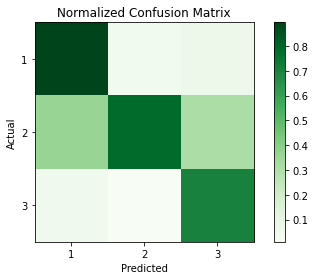

Overall Statistics:

Accuracy: 0.8124174372523117
Population: 757

Class Statistics:

       label   TP  FP   FN  Population  Precision    Recall
0     cement  204  95   24         228   0.682274  0.894737
1  landcover  370  25  101         471   0.936709  0.785563
2      steel   41  22   17          58   0.650794  0.706897


In [21]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 1:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_densenet161_1), np.array(valid_y_1))
printOverallStats(np.array(valid_preds_densenet161_1), np.array(valid_y_1))
printClassStats(np.array(valid_preds_densenet161_1), np.array(valid_y_1))

VALIDATION RESULTS - 2:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        181         35     12  228
landcover     102        336     33  471
steel           6          6     46   58
All           289        377     91  757




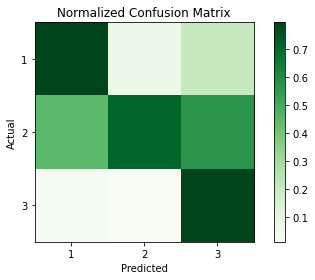

Overall Statistics:

Accuracy: 0.7437252311756936
Population: 757

Class Statistics:

       label   TP   FP   FN  Population  Precision    Recall
0     cement  181  108   47         228   0.626298  0.793860
1  landcover  336   41  135         471   0.891247  0.713376
2      steel   46   45   12          58   0.505495  0.793103


In [22]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 2:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_densenet161_2), np.array(valid_y_2))
printOverallStats(np.array(valid_preds_densenet161_2), np.array(valid_y_2))
printClassStats(np.array(valid_preds_densenet161_2), np.array(valid_y_2))

### ResNet50 MultiClass Model Results

VALIDATION RESULTS - 1:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        195         26      7  228
landcover      79        371     21  471
steel           7          5     46   58
All           281        402     74  757




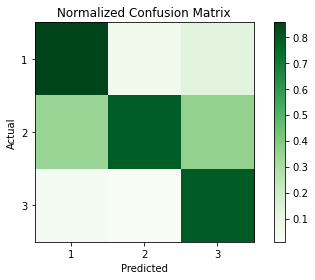

Overall Statistics:

Accuracy: 0.808454425363276
Population: 757

Class Statistics:

       label   TP  FP   FN  Population  Precision    Recall
0     cement  195  86   33         228   0.693950  0.855263
1  landcover  371  31  100         471   0.922886  0.787686
2      steel   46  28   12          58   0.621622  0.793103


In [23]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 1:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_resnet50_1), np.array(valid_y_1))
printOverallStats(np.array(valid_preds_resnet50_1), np.array(valid_y_1))
printClassStats(np.array(valid_preds_resnet50_1), np.array(valid_y_1))

VALIDATION RESULTS - 2:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        192         26     10  228
landcover      83        362     26  471
steel           4         10     44   58
All           279        398     80  757




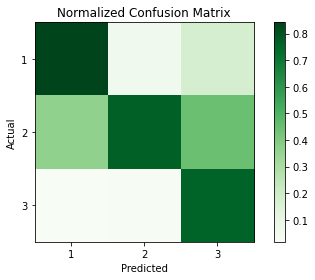

Overall Statistics:

Accuracy: 0.7899603698811096
Population: 757

Class Statistics:

       label   TP  FP   FN  Population  Precision    Recall
0     cement  192  87   36         228   0.688172  0.842105
1  landcover  362  36  109         471   0.909548  0.768577
2      steel   44  36   14          58   0.550000  0.758621


In [24]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 2:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_resnet50_2), np.array(valid_y_2))
printOverallStats(np.array(valid_preds_resnet50_2), np.array(valid_y_2))
printClassStats(np.array(valid_preds_resnet50_2), np.array(valid_y_2))

### VGG13 MultiClass Model Results

VALIDATION RESULTS - 1:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        205         20      3  228
landcover      83        370     18  471
steel          10          4     44   58
All           298        394     65  757




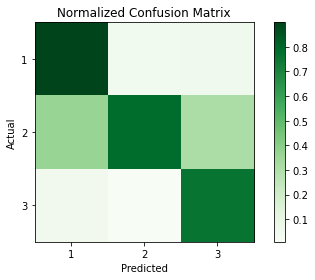

Overall Statistics:

Accuracy: 0.8177014531043593
Population: 757

Class Statistics:

       label   TP  FP   FN  Population  Precision    Recall
0     cement  205  93   23         228   0.687919  0.899123
1  landcover  370  24  101         471   0.939086  0.785563
2      steel   44  21   14          58   0.676923  0.758621


In [25]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 1:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_vgg13_1), np.array(valid_y_1))
printOverallStats(np.array(valid_preds_vgg13_1), np.array(valid_y_1))
printClassStats(np.array(valid_preds_vgg13_1), np.array(valid_y_1))

VALIDATION RESULTS - 2:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        195         26      7  228
landcover     101        350     20  471
steel           5         10     43   58
All           301        386     70  757




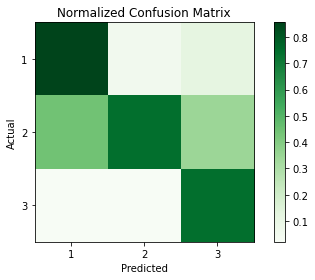

Overall Statistics:

Accuracy: 0.7767503302509907
Population: 757

Class Statistics:

       label   TP   FP   FN  Population  Precision    Recall
0     cement  195  106   33         228   0.647841  0.855263
1  landcover  350   36  121         471   0.906736  0.743100
2      steel   43   27   15          58   0.614286  0.741379


In [26]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 2:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_vgg13_2), np.array(valid_y_2))
printOverallStats(np.array(valid_preds_vgg13_2), np.array(valid_y_2))
printClassStats(np.array(valid_preds_vgg13_2), np.array(valid_y_2))

### Ensemble MultiClass Model Results

VALIDATION RESULTS - 1:

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        208         17      3  228
landcover      76        381     14  471
steel           9          5     44   58
All           293        403     61  757




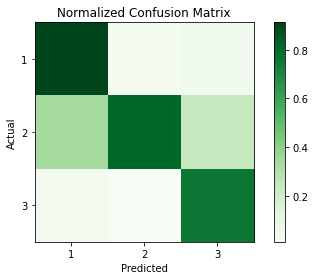

Overall Statistics:

Accuracy: 0.8361955085865258
Population: 757

Class Statistics:

       label   TP  FP  FN  Population  Precision    Recall
0     cement  208  85  20         228   0.709898  0.912281
1  landcover  381  22  90         471   0.945409  0.808917
2      steel   44  17  14          58   0.721311  0.758621


In [27]:
print("\033[1m\033[4m" + "VALIDATION RESULTS - 1:" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_ensemble_1), np.array(valid_y_1))
printOverallStats(np.array(valid_preds_ensemble_1), np.array(valid_y_1))
printClassStats(np.array(valid_preds_ensemble_1), np.array(valid_y_1))

VALIDATION RESULTS: - 2

Confusion matrix:

Predicted  cement  landcover  steel  All
Actual                                  
cement        190         31      7  228
landcover      87        360     24  471
steel           5         10     43   58
All           282        401     74  757




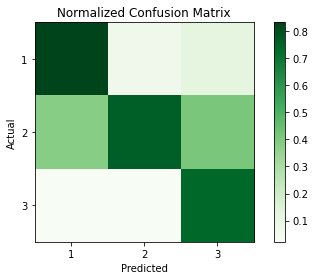

Overall Statistics:

Accuracy: 0.7833553500660502
Population: 757

Class Statistics:

       label   TP  FP   FN  Population  Precision    Recall
0     cement  190  92   38         228   0.673759  0.833333
1  landcover  360  41  111         471   0.897756  0.764331
2      steel   43  31   15          58   0.581081  0.741379


In [28]:
print("\033[1m\033[4m" + "VALIDATION RESULTS: - 2" + "\033[0m\n")

showConfusionMatrix(np.array(valid_preds_ensemble_2), np.array(valid_y_2))
printOverallStats(np.array(valid_preds_ensemble_2), np.array(valid_y_2))
printClassStats(np.array(valid_preds_ensemble_2), np.array(valid_y_2))